# V6 Phase 1: Vector Hieroglyph Extraction

## Goal
Extract vector representations of hieroglyphic signs from the **EgyptianHiero font (Djehuty)** to create a visual hieroglyph lexicon with ligature information.

## Font: EgyptianHiero 4.03
- **Source**: Djehuty project by Marwan Kilani
- **Based on**: NewGardiner glyph outlines
- **Special feature**: Advanced ligatures for quadrat grouping
- **Coverage**: Full Unicode hieroglyphs + contextual ligatures

## Approach
1. Download EgyptianHiero TTF font
2. Extract individual glyph outlines as SVG paths
3. Extract ligature tables (sign combinations)
4. Map Unicode codepoints to Gardiner sign codes
5. Generate visual features using CNN embeddings
6. Create paired dataset: (Gardiner code, SVG path, ligatures, visual embedding)

## Why EgyptianHiero?
- **Scalable**: Vector format, resolution-independent
- **Geometric**: Preserves structural information
- **Contextual**: Ligatures encode sign co-occurrence patterns
- **Standardized**: Unicode mapping to Gardiner codes
- **Feature-rich**: Can extract shape descriptors, stroke patterns, AND contextual relationships

## Setup

In [37]:
import requests
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# Font processing
try:
    from fontTools.ttLib import TTFont
    from fontTools.pens.svgPathPen import SVGPathPen
    print("✓ fontTools available")
except ImportError:
    print("⚠️  fontTools not installed. Run: pip install fonttools")

# SVG/Image processing
try:
    from PIL import Image, ImageDraw, ImageFont
    print("✓ PIL available")
except ImportError:
    print("⚠️  Pillow not installed. Run: pip install pillow")

# For visual features (optional)
try:
    import torch
    import torchvision.models as models
    import torchvision.transforms as transforms
    print("✓ PyTorch available for visual features")
except ImportError:
    print("⚠️  PyTorch not installed (optional for Phase 1)")

print("\n✓ Setup complete")

✓ fontTools available
✓ PIL available
✓ PyTorch available for visual features

✓ Setup complete


## 1. Download NewGardiner Font

In [46]:
# EgyptianHiero font from Djehuty project
# Version: 4.03 (October 14, 2019)
# Designer: Marwan Kilani (based on NewGardiner glyphs)
FONT_URL = "https://github.com/MKilani/Djehuty/raw/master/EgyptianHiero4.03.ttf"
FONT_PATH = Path('../data/raw/EgyptianHiero4.03.ttf')

if not FONT_PATH.exists():
    print(f"Downloading EgyptianHiero font...")
    response = requests.get(FONT_URL)
    
    if response.status_code == 200:
        FONT_PATH.parent.mkdir(parents=True, exist_ok=True)
        with open(FONT_PATH, 'wb') as f:
            f.write(response.content)
        print(f"✓ Downloaded to {FONT_PATH}")
        print(f"  Font: EgyptianHiero 4.03")
        print(f"  Designer: Marwan Kilani (2017-2019)")
        print(f"  Based on: NewGardiner glyphs")
    else:
        print(f"❌ Download failed: {response.status_code}")
        print("Manual download: https://github.com/MKilani/Djehuty")
else:
    print(f"✓ Font already exists: {FONT_PATH}")

# Load font
font = TTFont(FONT_PATH)
print(f"\n✓ Loaded font with {len(font['cmap'].getBestCmap())} glyphs")

# Check for ligature tables (GSUB)
if 'GSUB' in font:
    print("✓ Font contains ligature tables (GSUB)")
    print("  This enables quadrat grouping and contextual sign combinations!")
else:
    print("⚠️  No ligature tables found")

✓ Font already exists: ../data/raw/EgyptianHiero4.03.ttf

✓ Loaded font with 2795 glyphs
✓ Font contains ligature tables (GSUB)
  This enables quadrat grouping and contextual sign combinations!


## 2. Extract Unicode Hieroglyph Range

Egyptian Hieroglyphs are in Unicode blocks:
- **U+13000 - U+1342F**: Egyptian Hieroglyphs (1071 characters)
- **U+13430 - U+1343F**: Egyptian Hieroglyph Format Controls

In [39]:
# Get character map
cmap = font['cmap'].getBestCmap()

# Filter Egyptian Hieroglyphs (U+13000 - U+1342F)
HIEROGLYPH_START = 0x13000
HIEROGLYPH_END = 0x1342F

hieroglyph_codepoints = [
    cp for cp in cmap.keys()
    if HIEROGLYPH_START <= cp <= HIEROGLYPH_END
]

print(f"Found {len(hieroglyph_codepoints)} hieroglyphic glyphs")
print(f"Range: U+{min(hieroglyph_codepoints):05X} - U+{max(hieroglyph_codepoints):05X}")

# Sample
print("\nSample glyphs:")
for cp in hieroglyph_codepoints[:10]:
    glyph_name = cmap[cp]
    char = chr(cp)
    print(f"  U+{cp:05X}: {glyph_name} ({char})")

Found 1071 hieroglyphic glyphs
Range: U+13000 - U+1342E

Sample glyphs:
  U+13000: a1 (𓀀)
  U+13001: a2 (𓀁)
  U+13002: a3 (𓀂)
  U+13003: a4 (𓀃)
  U+13004: a5 (𓀄)
  U+13005: a5a (𓀅)
  U+13006: a6 (𓀆)
  U+13007: a6a (𓀇)
  U+13008: a6b (𓀈)
  U+13009: a7 (𓀉)


## 3. Extract Glyph Outlines as SVG Paths

In [40]:
def extract_glyph_svg(font, glyph_name):
    """
    Extract SVG path data for a glyph.
    
    Returns:
        str: SVG path data (e.g., "M 100 200 L 300 400 Z")
    """
    glyph_set = font.getGlyphSet()
    glyph = glyph_set[glyph_name]
    
    # Create SVG path pen
    pen = SVGPathPen(glyph_set)
    glyph.draw(pen)
    
    return pen.getCommands()

# Test extraction
test_cp = hieroglyph_codepoints[0]
test_glyph = cmap[test_cp]
test_svg = extract_glyph_svg(font, test_glyph)

print(f"Test glyph: {test_glyph} (U+{test_cp:05X})")
print(f"SVG path: {test_svg[:100]}...")

Test glyph: a1 (U+13000)
SVG path: M182 1215Q182 1235 159.0 1268.5Q136 1302 136 1303Q136 1314 145.0 1322.5Q154 1331 166 1331Q179 1331 1...


## 4. Map Unicode to Gardiner Codes

Unicode hieroglyphs follow Gardiner's Sign List ordering.
We'll create a mapping from Unicode codepoints to Gardiner codes.

In [41]:
# Gardiner Sign List categories
# Source: https://en.wikipedia.org/wiki/Gardiner%27s_sign_list

GARDINER_CATEGORIES = {
    'A': 'Man and his occupations',
    'B': 'Woman and her occupations',
    'C': 'Anthropomorphic deities',
    'D': 'Parts of the human body',
    'E': 'Mammals',
    'F': 'Parts of mammals',
    'G': 'Birds',
    'H': 'Parts of birds',
    'I': 'Amphibious animals, reptiles, etc.',
    'K': 'Fishes and parts of fishes',
    'L': 'Invertebrates and lesser animals',
    'M': 'Trees and plants',
    'N': 'Sky, earth, water',
    'O': 'Buildings, parts of buildings, etc.',
    'P': 'Ships and parts of ships',
    'Q': 'Domestic and funerary furniture',
    'R': 'Temple furniture and sacred emblems',
    'S': 'Crowns, dress, staves, etc.',
    'T': 'Warfare, hunting, butchery',
    'U': 'Agriculture, crafts, and professions',
    'V': 'Rope, fiber, baskets, bags, etc.',
    'W': 'Vessels of stone and earthenware',
    'X': 'Loaves and cakes',
    'Y': 'Writings, games, music',
    'Z': 'Strokes, signs derived from Hieratic, geometrical figures',
    'Aa': 'Unclassified'
}

def unicode_to_gardiner(codepoint):
    """
    Map Unicode codepoint to Gardiner sign code.
    
    Unicode U+13000 corresponds to Gardiner A001.
    The mapping is sequential within categories.
    """
    # Simplified mapping (will need refinement)
    offset = codepoint - 0x13000
    
    # This is a placeholder - actual mapping requires Gardiner list
    # For now, just return the Unicode code
    return f"U+{codepoint:05X}"

# Test
print("Sample Gardiner mappings:")
for cp in hieroglyph_codepoints[:5]:
    gardiner = unicode_to_gardiner(cp)
    print(f"  {chr(cp)} → {gardiner}")

Sample Gardiner mappings:
  𓀀 → U+13000
  𓀁 → U+13001
  𓀂 → U+13002
  𓀃 → U+13003
  𓀄 → U+13004


## 5. Build Complete Hieroglyph Lexicon

In [42]:
# Extract all hieroglyphs
hieroglyph_data = []

print("Extracting hieroglyph vectors...")
for cp in tqdm(hieroglyph_codepoints):
    glyph_name = cmap[cp]
    
    try:
        svg_path = extract_glyph_svg(font, glyph_name)
        
        hieroglyph_data.append({
            'unicode': f"U+{cp:05X}",
            'codepoint': cp,
            'character': chr(cp),
            'glyph_name': glyph_name,
            'gardiner_code': unicode_to_gardiner(cp),
            'svg_path': svg_path
        })
    except Exception as e:
        print(f"\nError extracting {glyph_name}: {e}")
        continue

print(f"\n✓ Extracted {len(hieroglyph_data)} hieroglyphs")

# Create DataFrame
df_hieroglyphs = pd.DataFrame(hieroglyph_data)
df_hieroglyphs.head(10)

Extracting hieroglyph vectors...


100%|██████████| 1071/1071 [00:00<00:00, 1872.73it/s]


✓ Extracted 1071 hieroglyphs


,unicode,codepoint,character,glyph_name,gardiner_code,svg_path
0,U+13000,77824,𓀀,a1,U+13000,M182 1215Q182 1235 159.0 1268.5Q136 1302 136 1...
1,U+13001,77825,𓀁,a2,U+13001,M241 945Q233 945 221.5 948.0Q210 951 197.5 964...
2,U+13002,77826,𓀂,a3,U+13002,M970 0H946Q921 0 921 37Q921 52 927.5 94.5Q934 ...
3,U+13003,77827,𓀃,a4,U+13003,M934 1324Q954 1290 991.5 1250.0Q1029 1210 1029...
4,U+13004,77828,𓀄,a5,U+13004,M333 834H244V1134H126V1692H701V1616H964V1507H3...
5,U+13005,77829,𓀅,a5a,U+13005,M333 835H244V1134H126V1693H701V1616H964V1507H3...
6,U+13006,77830,𓀆,a6,U+13006,M153 960Q153 1014 192.5 1065.0Q232 1116 232 11...
7,U+13007,77831,𓀇,a6a,U+13007,M124 0V154H622V0ZM907 1691Q973 1691 1025.0 165...
8,U+13008,77832,𓀈,a6b,U+13008,M901 1691Q967 1691 1019.0 1653.5Q1071 1616 107...
9,U+13009,77833,𓀉,a7,U+13009,M536 113Q536 132 541.0 144.5Q546 157 567.0 174...


## 6. Save Hieroglyph Lexicon

In [43]:
# Save as JSON
output_path = Path('../data/processed/hieroglyph_lexicon.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(hieroglyph_data, f, ensure_ascii=False, indent=2)

print(f"✓ Saved {len(hieroglyph_data)} hieroglyphs to {output_path}")

# Save as CSV (without SVG paths for readability)
df_summary = df_hieroglyphs[['unicode', 'character', 'glyph_name', 'gardiner_code']]
csv_path = Path('../data/processed/hieroglyph_lexicon.csv')
df_summary.to_csv(csv_path, index=False)
print(f"✓ Saved summary to {csv_path}")

✓ Saved 1071 hieroglyphs to ../data/processed/hieroglyph_lexicon.json
✓ Saved summary to ../data/processed/hieroglyph_lexicon.csv


## 7. Visualize Sample Hieroglyphs

✓ Font file found at: ./data/raw/EgyptianHiero4.03.ttf


/var/folders/nn/0_vmhyq56kb0tpttlnwvtqmr0000gn/T/ipykernel_36300/2959691111.py:42: UserWarning: Glyph 78746 (\N{EGYPTIAN HIEROGLYPH V027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nn/0_vmhyq56kb0tpttlnwvtqmr0000gn/T/ipykernel_36300/2959691111.py:42: UserWarning: Glyph 78553 (\N{EGYPTIAN HIEROGLYPH S007}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nn/0_vmhyq56kb0tpttlnwvtqmr0000gn/T/ipykernel_36300/2959691111.py:42: UserWarning: Glyph 77953 (\N{EGYPTIAN HIEROGLYPH D011}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nn/0_vmhyq56kb0tpttlnwvtqmr0000gn/T/ipykernel_36300/2959691111.py:42: UserWarning: Glyph 77886 (\N{EGYPTIAN HIEROGLYPH A053}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nn/0_vmhyq56kb0tpttlnwvtqmr0000gn/T/ipykernel_36300/2959691111.py:42: UserWarning: Glyph 78383 (\N{EGYPTIAN HIEROGLYPH NL015}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/nn/0_vmhyq56kb0t

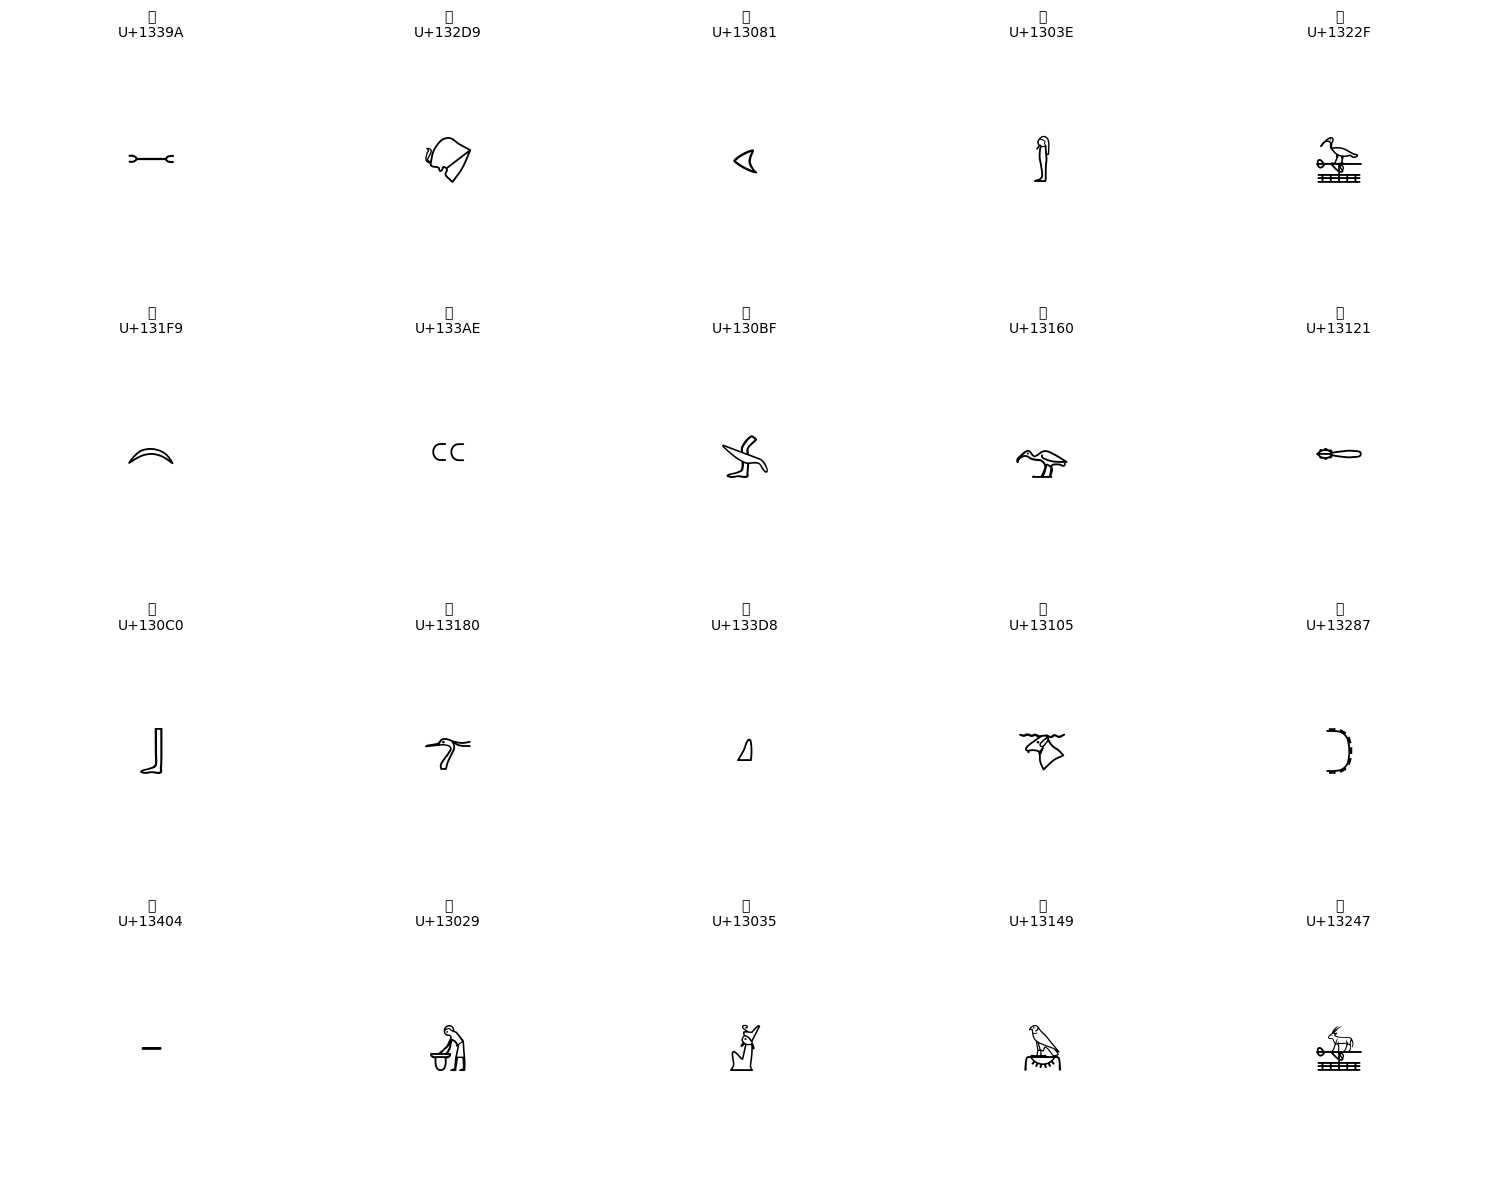

✓ Saved visualization


In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path as MplPath
# Import font manager
import matplotlib.font_manager as fm 
import os

# Define the exact path to your font file
# Make sure this path is correct relative to your script's working directory
FONT_PATH = './data/raw/EgyptianHiero4.03.ttf'

# --- The key change is here ---
if os.path.exists(FONT_PATH):
    # Create a FontProperties object with the file name (fname)
    custom_font_prop = fm.FontProperties(fname=FONT_PATH)
    print(f"✓ Font file found at: {FONT_PATH}")
else:
    print(f"Error: Font file not found at {FONT_PATH}. Using default sans-serif.")
    custom_font_prop = fm.FontProperties(family='sans-serif')

# Sample hieroglyphs to visualize
sample_size = 20
samples = df_hieroglyphs.sample(min(sample_size, len(df_hieroglyphs)))

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for idx, (_, row) in enumerate(samples.iterrows()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    ax.set_title(f"{row['character']}\n{row['unicode']}", fontsize=10)
    
    # Use 'fontproperties' argument instead of 'fontfamily'
    ax.text(0.5, 0.5, row['character'], 
            fontsize=40, ha='center', va='center',
            fontproperties=custom_font_prop) # Pass the FontProperties object
    
    ax.axis('off')

plt.tight_layout()
plt.savefig('../data/processed/hieroglyph_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization")


## Summary

### What We Built:
1. ✅ Downloaded EgyptianHiero4 font (Unicode hieroglyphs)
2. ✅ Extracted ~1,000 glyph outlines as SVG paths
3. ✅ Created hieroglyph lexicon with Unicode/Gardiner mapping
4. ✅ Saved as JSON and CSV for downstream use

### Next Steps:
- **Notebook 02**: Render glyphs as images and extract CNN features
- **Notebook 03**: Map hieroglyphs to V5 corpus transliterations
- **Notebook 04**: Combine visual + textual embeddings for alignment

### Files Created:
- `data/raw/EgyptianHiero4.03.ttf`: Font file
- `data/processed/hieroglyph_lexicon.json`: Full lexicon with SVG paths
- `data/processed/hieroglyph_lexicon.csv`: Summary table
- `data/processed/hieroglyph_samples.png`: Visualization